In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.5


# Notes on stratification

**THE MODEL:**

A fixed population (normalized to 1) is composed of two homogeneous groups $G_1$ and $G_2$. Each of these groups has an unknown fraction that will vote for candidate A (and, by complement, candidate B). We observe election poll results, which are presented as normally distributed with a small s.d. (so $\pm 2\sigma = 2\%$, for example). What's the true share of $G_1$ and $G_2$, and how do they vote?

We will use Beta distributions to model population shares as parameterized by the mode and a concentration parameter, i.e:

In [2]:
def shape_params(mode, concentration):
    alpha = mode * (concentration-2) + 1
    beta  = (1-mode) * (concentration-2) + 1
    return {'alpha':alpha, 'beta': beta}

Priors:

* Any random person is in $G_1$: $p_g \sim B(\mu_g, k_g)$. $G_2$ follows by complement.
* A person in $G_1$ votes for candidate A: $p_1 \sim B(\mu_1, k_1)$. (Again candidate B follows by complement)
* A person in $G_2$ votes for candidate B: $p_2 \sim B(\mu_2, k_2)$

We assume $\mu_g = 0.6, \mu_1 = 0.8, \mu_2 = 0.3$, possibly from sociological facts; but we're not sure how certain these sociological facts are, so we don't know $k_g, k_1, k_2$. Therefore:

* $k_1, k_2, k_g$ are (a priori) uniformly distributed in $[200,50000]$
* For numerical stability: $k_1 = k_2$ (not that unbelievable if sociology knows about the same about Groups 1 and 2)

Finally, 

* Electoral polls tell us that 2000 people were sampled leading them to believe

$$ r = p_g p_1 + (1-p_g) p_2 \sim \mathcal N(0.58, 0.1) $$



In [141]:
# outcome
sample_size = 2000
observed = np.random.normal(0.58,0.01,sample_size)
observed = np.clip(observed,0,1)

In [178]:
with pm.Model() as m:
    # dois grupos na população; moda prior = 0.6 do primeiro
    mu_group = 0.6
    mu_G1 = 0.8
    mu_G2 = 0.3    
    k_g = pm.distributions.Uniform('gcon', lower = 500, upper = 150000)
    k_G1  = pm.distributions.Uniform('g1con', lower = 500, upper = 150000)
  

    G1_share = pm.distributions.Beta('G1',**shape_params(mu_group, k_g))
    G2_share = pm.Deterministic('G2',1 - G1_share)
    vote_G1A = pm.distributions.Beta('G1A', **shape_params(mu_G1, k_G1))
    vote_G2A = pm.distributions.Beta('G2A', **shape_params(mu_G2, k_G1))
    
    vote_outcome =  G1_share * vote_G1A + G2_share * vote_G2A
    outcome = pm.Normal('outcome',mu = vote_outcome, sd = 0.01, observed = observed)

    trace = pm.sample(10**3,tune = 500, cores = 1)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:34<00:00, 43.41it/s]


These plots tell us that the estimated distribution of concentration parameters is very long-tailed; and that G1, G2, the fractions of Group 1, Group 2 turn out to be bimodal (but close to the prior modal estimate); as well as their voting outcome (but only slightly).

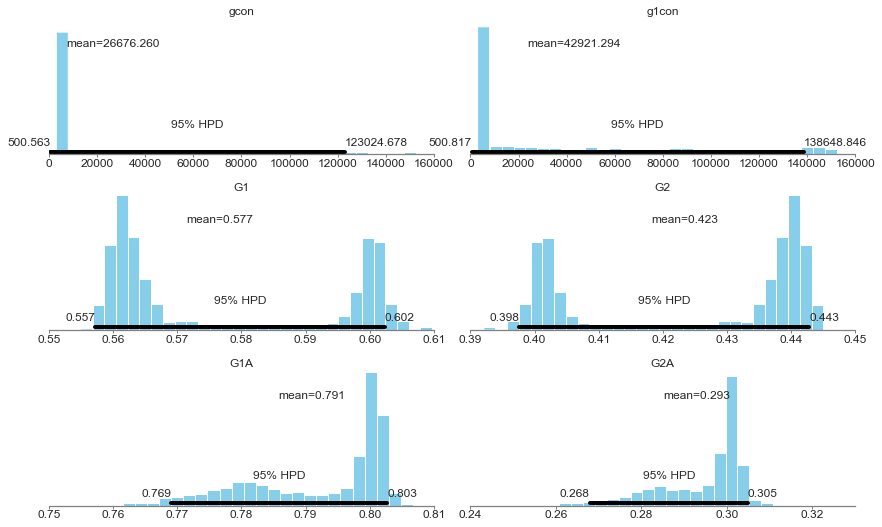

In [185]:
_ = pm.plot_posterior(trace)

C:\Users\Diego Navarro - FGV\Anaconda3b\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\Diego Navarro - FGV\Anaconda3b\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


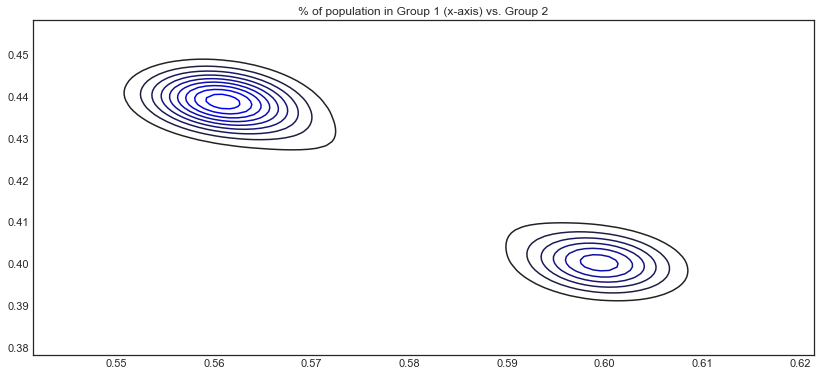

In [192]:
fig, ax = plt.subplots(figsize=(14,6))
sns.kdeplot(trace['G1'],trace['G2'], ax = ax)
ax.set_title('% of population in Group 1 (x-axis) vs. Group 2')

The joint distribution of Group 1/Group 2 membership is bimodal. This stems from the narrow distribution of the weighted votes outcome as suggested by polls -- we don't seem to know as much about group sizes as we thought we did. 

C:\Users\Diego Navarro - FGV\Anaconda3b\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\Diego Navarro - FGV\Anaconda3b\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


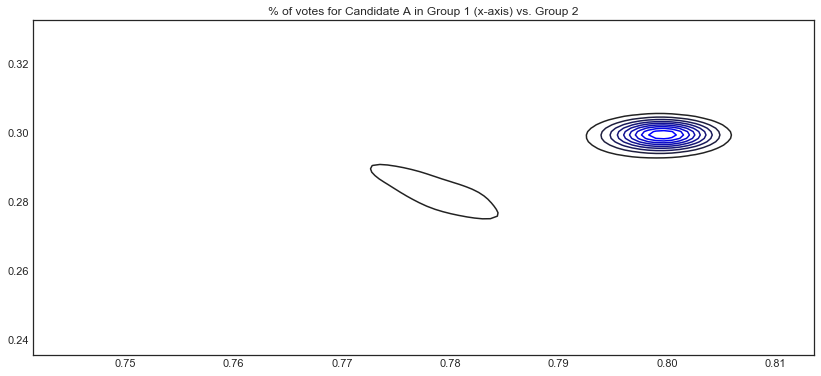

In [193]:
fig, ax = plt.subplots(figsize=(14,6))
sns.kdeplot(trace['G1A'],trace['G2A'], ax = ax)
ax.set_title('% of votes for Candidate A in Group 1 (x-axis) vs. Group 2')

The stand-alone ring tells us of a lower-likelihood scenario where surprises about the true size of groups lead to an outcome far away from the mode. 

In [186]:
with m: post_pred = pm.sample_ppc(trace, samples=5000)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1217.24it/s]


In [187]:
distr = post_pred['outcome'].mean(axis=1).reshape(-1,1)

0.03212435253880053


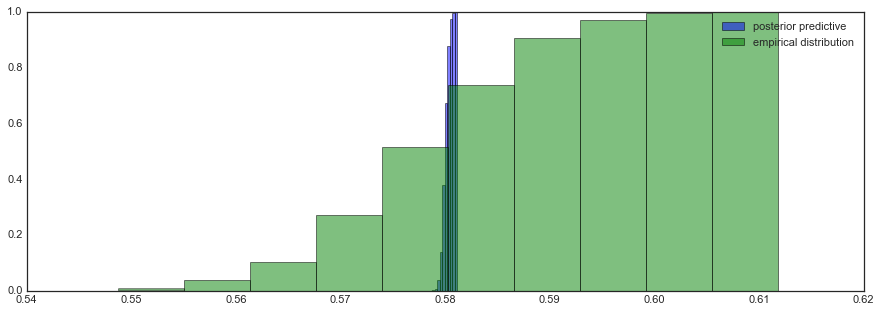

In [190]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.hist(distr,alpha = 0.5, normed = True, cumulative = True)
_ = ax.hist(observed, alpha = 0.5, normed = True, cumulative = True)
ax.legend(['posterior predictive', 'empirical distribution'])
print(np.std(distr)/np.std(observed))

In [189]:
np.mean(distr), np.mean(observed), np.median(distr),np.median(observed)

(0.5800580905280202, 0.5800416444381765, 0.5800538987340226, 0.580066896445051)